# Data extraction

In [ ]:

from datetime import datetime, timedelta
import pandas as pd
import backtrader as bt



full_df = pd.read_csv('us_banks.csv')

# Étape 1 : conversion explicite en datetime (si ce n'est pas déjà le cas)
full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')
# Étape 2 : enlever le fuseau horaire SANS conversion d'heure
# (on enlève tzinfo mais on garde l'heure locale telle quelle)
full_df['date'] = full_df['date'].apply(lambda dt: dt.replace(tzinfo=None) if pd.notna(dt) else dt)


# Étape 2: sélectionner les colonnes d'intérêt
cols = ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
full_df = full_df[cols]

# Étape 3: pivot en colonnes multiples
df_wide = full_df.pivot(index='date', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])

# Étape 4: réordonner les colonnes si tu veux (facultatif)
df_wide = df_wide.reorder_levels([1, 0], axis=1).sort_index(axis=1)

# Étape 5: fixer l'index datetime
df_wide.index = pd.to_datetime(df_wide.index)





C:\Users\JEAUL2\AppData\Local\Temp\ipykernel_8620\2011403135.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')


# We will backtest across multiple pairs and exclude the first and last 30 minutes of trading. We will also train the statistical model on the previous day’s data. We will save the results in the pickle file resultat.

In [4]:
from portfolio_pair.backtest_multipair import PortfolioBacktest
from single_pair.dependence_modeling import *



symbols = ['JPM', 'BAC', 'C', 'WFC', 'USB',
           'PNC', 'TFC', 'GS', 'MS', 'SCHW']

params_config = dict(
    training_day=1,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch,
    profit_target=0,
    edge_buffer=6
    )



backtest = PortfolioBacktest(
    stocks=symbols,
    df=df_wide,
    fees=0,
    params=params_config,
    nom_fichier_result='resultat'
)


backtest.run() 
    

Backtesting pairs: 100%|██████████| 45/45 [2:20:49<00:00, 187.77s/it]


JPM                                              \
                           BAC          C        WFC        USB        PNC   
2020-06-11 10:00:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:05:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:10:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:15:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:20:00  100000.00  100000.00  100000.00  100000.00  100000.00   
...                        ...        ...        ...        ...        ...   
2025-06-13 15:10:00  137966.95  126035.76  152183.31  133280.14  129393.33   
2025-06-13 15:15:00  137993.45  126035.76  152183.31  133280.14  129393.33   
2025-06-13 15:20:00  137955.85  126035.76  152183.31  133280.14  129393.33   
2025-06-13 15:25:00  137967.37  126035.76  152183.31  133280.14  129393.33   
2025-06-13 15:55:00  137906.91        NaN        NaN        NaN        NaN   

                                                                       BAC  \
                           TFC         GS         MS       SCHW          C   
2020-06-11 10:00:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:05:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:10:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:15:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-11 10:20:00  100000.00  100000.00  100000.00  100000.00  100000.00   
...                        ...        ...        ...        ...        ...   
2025-06-13 15:10:00  122401.70  133575.09  156207.99  119439.68  140705.65   
2025-06-13 15:15:00  122427.31  133575.09  156207.99  119439.68  140729.24   
2025-06-13 15:20:00  122427.31  133575.09  156207.99  119439.68  140820.87   
2025-06-13 15:25:00  122427.31  133575.09  156207.99  119439.68  140798.19   
2025-06-13 15:55:00        NaN        NaN        NaN        NaN        NaN   

                     ...       PNC                                      TFC  \
                     ...       TFC        GS        MS      SCHW         GS   
2020-06-11 10:00:00  ...  100000.0  100000.0  100000.0  100000.0  100000.00   
2020-06-11 10:05:00  ...  100000.0  100000.0  100000.0  100000.0  100000.00   
2020-06-11 10:10:00  ...  100000.0  100000.0  100000.0  100000.0  100000.00   
2020-06-11 10:15:00  ...  100000.0  100000.0  100000.0  100000.0  100000.00   
2020-06-11 10:20:00  ...  100000.0  100000.0  100000.0  100000.0  100000.00   
...                  ...       ...       ...       ...       ...        ...   
2025-06-13 15:10:00  ...       NaN       NaN       NaN  113877.6  108815.02   
2025-06-13 15:15:00  ...       NaN       NaN       NaN  113889.1  108815.02   
2025-06-13 15:20:00  ...       NaN       NaN       NaN  113889.1  108815.02   
2025-06-13 15:25:00  ...       NaN       NaN       NaN  113889.1  108815.02   
2025-06-13 15:55:00  ...       NaN       NaN       NaN       NaN        NaN   

                                                 GS                    MS  
                            MS       SCHW        MS       SCHW       SCHW  
2020-06-11 10:00:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-11 10:05:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-11 10:10:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-11 10:15:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-11 10:20:00  100000.00  100000.00  100000.0  100000.00  100000.00  
...                        ...        ...       ...        ...        ...  
2025-06-13 15:10:00  101176.82   86697.26       NaN  110028.79   77850.03  
2025-06-13 15:15:00  101176.82   86697.26       NaN  110028.79   77850.03  
2025-06-13 15:20:00  101176.82   86697.26       NaN  110028.79   77850.03  
2025-06-13 15:25:00  101176.82   86697.26       NaN  110028.79   77850.03  
2025-06-13 15:55:00        NaN        NaN       NaN      

# We will backtest across multiple pairs and exclude the first and last hours and half of trading. We will also train the statistical model on the previous three day’s data. We will save the results in the pickle file resultat2.

In [9]:
from portfolio_pair.backtest_multipair import PortfolioBacktest
from single_pair.dependence_modeling import *



symbols = ['JPM', 'BAC', 'C', 'WFC', 'USB',
           'PNC', 'TFC', 'GS', 'MS', 'SCHW']

params_config = dict(
    training_day=3,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch,
    profit_target=0,
    edge_buffer=18
    )



backtest = PortfolioBacktest(
    stocks=symbols,
    df=df_wide,
    fees=0,
    params=params_config,
    nom_fichier_result='resultat2'
)


backtest.run() 

Backtesting pairs: 100%|██████████| 45/45 [1:24:08<00:00, 112.18s/it]


JPM                                             \
                          BAC          C        WFC        USB       PNC   
2020-06-15 11:00:00  100000.0  100000.00  100000.00  100000.00  100000.0   
2020-06-15 11:05:00  100000.0  100000.00  100000.00  100000.00  100000.0   
2020-06-15 11:10:00  100000.0  100000.00  100000.00  100000.00  100000.0   
2020-06-15 11:15:00  100000.0  100000.00  100000.00  100000.00  100000.0   
2020-06-15 11:20:00  100000.0  100000.00  100000.00  100000.00  100000.0   
...                       ...        ...        ...        ...       ...   
2025-06-13 14:10:00  106063.1   99912.61  128106.81   99513.21       NaN   
2025-06-13 14:15:00  106063.1   99912.61  128106.81   99513.21       NaN   
2025-06-13 14:20:00  106063.1   99912.61  128106.81   99513.21       NaN   
2025-06-13 14:25:00  106063.1   99912.61  128106.81   99513.21       NaN   
2025-06-13 15:55:00       NaN        NaN        NaN        NaN       NaN   

                                                                       BAC  \
                           TFC         GS         MS       SCHW          C   
2020-06-15 11:00:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-15 11:05:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-15 11:10:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-15 11:15:00  100000.00  100000.00  100000.00  100000.00  100000.00   
2020-06-15 11:20:00  100000.00  100000.00  100000.00  100000.00  100000.00   
...                        ...        ...        ...        ...        ...   
2025-06-13 14:10:00  103347.87   93735.27  100535.94   96304.02  117819.57   
2025-06-13 14:15:00  103347.87   93735.27  100535.94   96304.02  117819.57   
2025-06-13 14:20:00  103347.87   93735.27  100535.94   96304.02  117819.57   
2025-06-13 14:25:00  103347.87   93735.27  100535.94   96304.02  117819.57   
2025-06-13 15:55:00        NaN        NaN        NaN        NaN        NaN   

                     ...       PNC                                       TFC  \
                     ...       TFC        GS        MS       SCHW         GS   
2020-06-15 11:00:00  ...  100000.0  100000.0  100000.0  100000.00  100000.00   
2020-06-15 11:05:00  ...  100000.0  100000.0  100000.0  100000.00  100000.00   
2020-06-15 11:10:00  ...  100000.0  100000.0  100000.0  100000.00  100000.00   
2020-06-15 11:15:00  ...  100000.0  100000.0  100000.0  100000.00  100000.00   
2020-06-15 11:20:00  ...  100000.0  100000.0  100000.0  100000.00  100000.00   
...                  ...       ...       ...       ...        ...        ...   
2025-06-13 14:10:00  ...       NaN       NaN       NaN   95289.03  106890.76   
2025-06-13 14:15:00  ...       NaN       NaN       NaN   95289.03  106890.76   
2025-06-13 14:20:00  ...       NaN       NaN       NaN   95289.03  106890.76   
2025-06-13 14:25:00  ...       NaN       NaN       NaN   95289.03  106890.76   
2025-06-13 15:55:00  ...       NaN       NaN       NaN        NaN        NaN   

                                                 GS                    MS  
                            MS       SCHW        MS       SCHW       SCHW  
2020-06-15 11:00:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-15 11:05:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-15 11:10:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-15 11:15:00  100000.00  100000.00  100000.0  100000.00  100000.00  
2020-06-15 11:20:00  100000.00  100000.00  100000.0  100000.00  100000.00  
...                        ...        ...       ...        ...        ...  
2025-06-13 14:10:00  101069.49   97498.44       NaN   92249.15  113276.09  
2025-06-13 14:15:00  101069.49   97498.44       NaN   92249.15  113276.09  
2025-06-13 14:20:00  101069.49   97498.44       NaN   92249.15  113276.09  
2025-06-13 14:25:00  101069.49   97498.44       NaN   92249.15  113276.09  
2025-06-13 15:55:00        NaN        NaN       NaN        NaN       

# Display the PnL of each pair

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import math


def print_trades(path):
    # Charger le DataFrame contenant les equity curves
    df = pd.read_pickle(path)  # adapte le nom si besoin

    # Paramètres d’affichage
    n_pairs = df.shape[1]
    n_cols = 3
    n_rows = math.ceil(n_pairs / n_cols)

    # Taille globale de la figure
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    # Tracer chaque equity curve
    for i, pair in enumerate(df.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        rendement_cumule = df[pair] / df[pair].iloc[0] - 1
        rendement_cumule.plot()
        plt.title(f"{pair[0]} / {pair[1]}")
        plt.xlabel("Date")
        plt.ylabel("Equity")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    




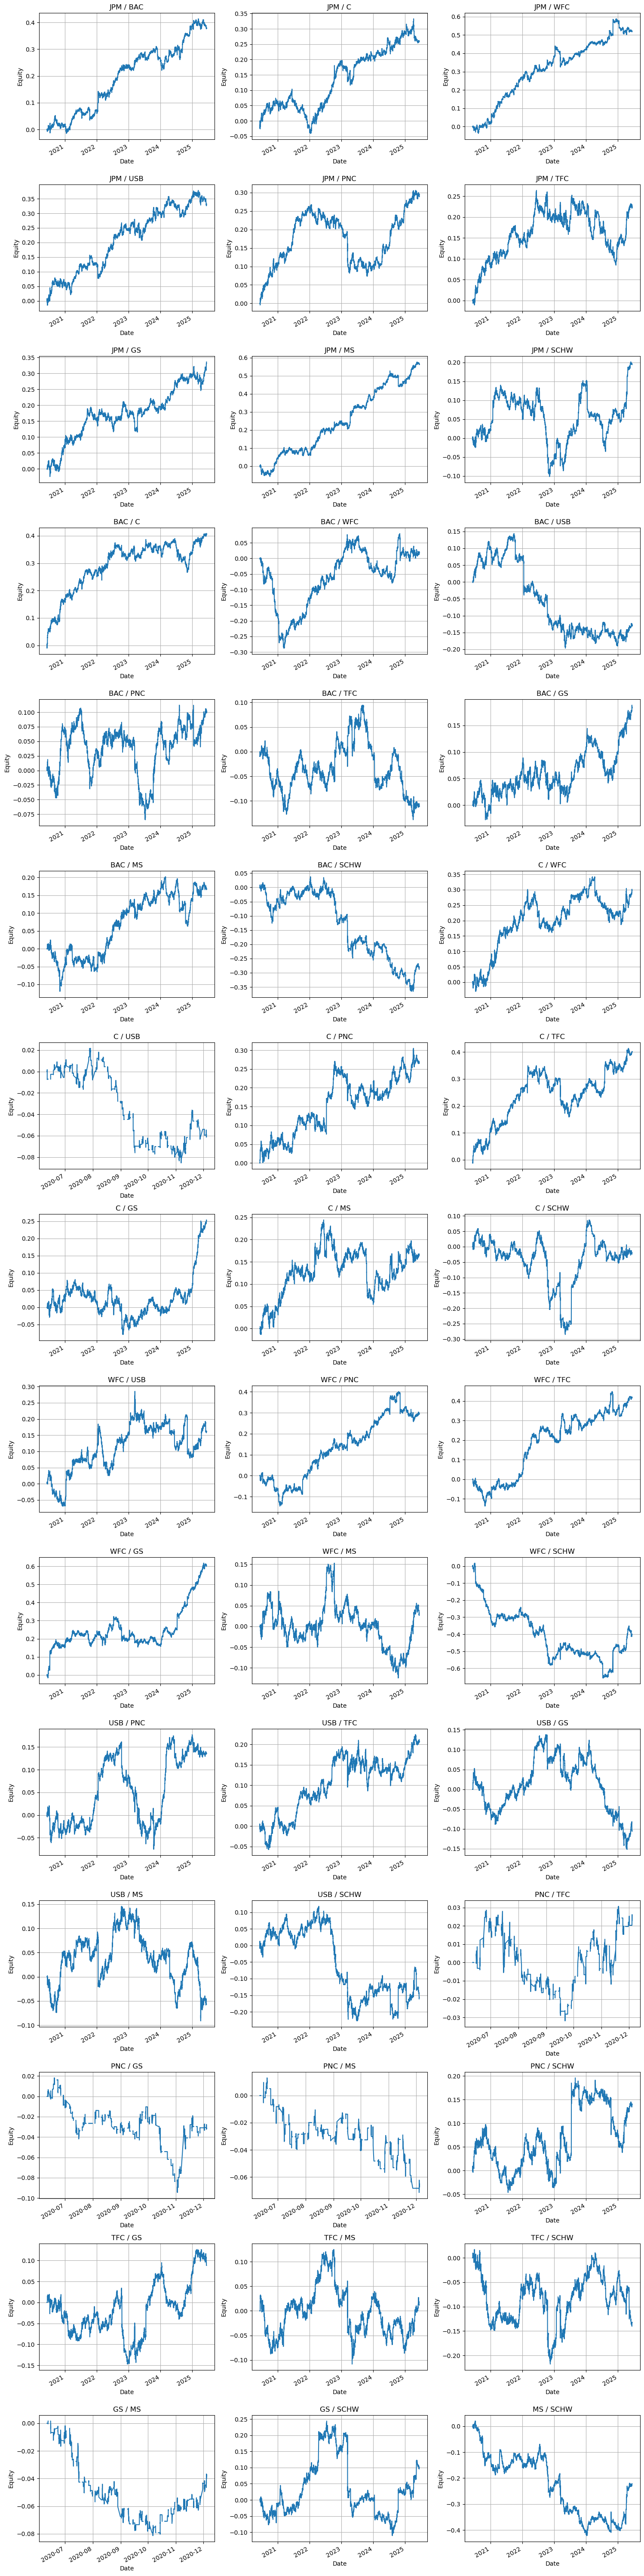

In [6]:
print_trades('resultat.pkl')

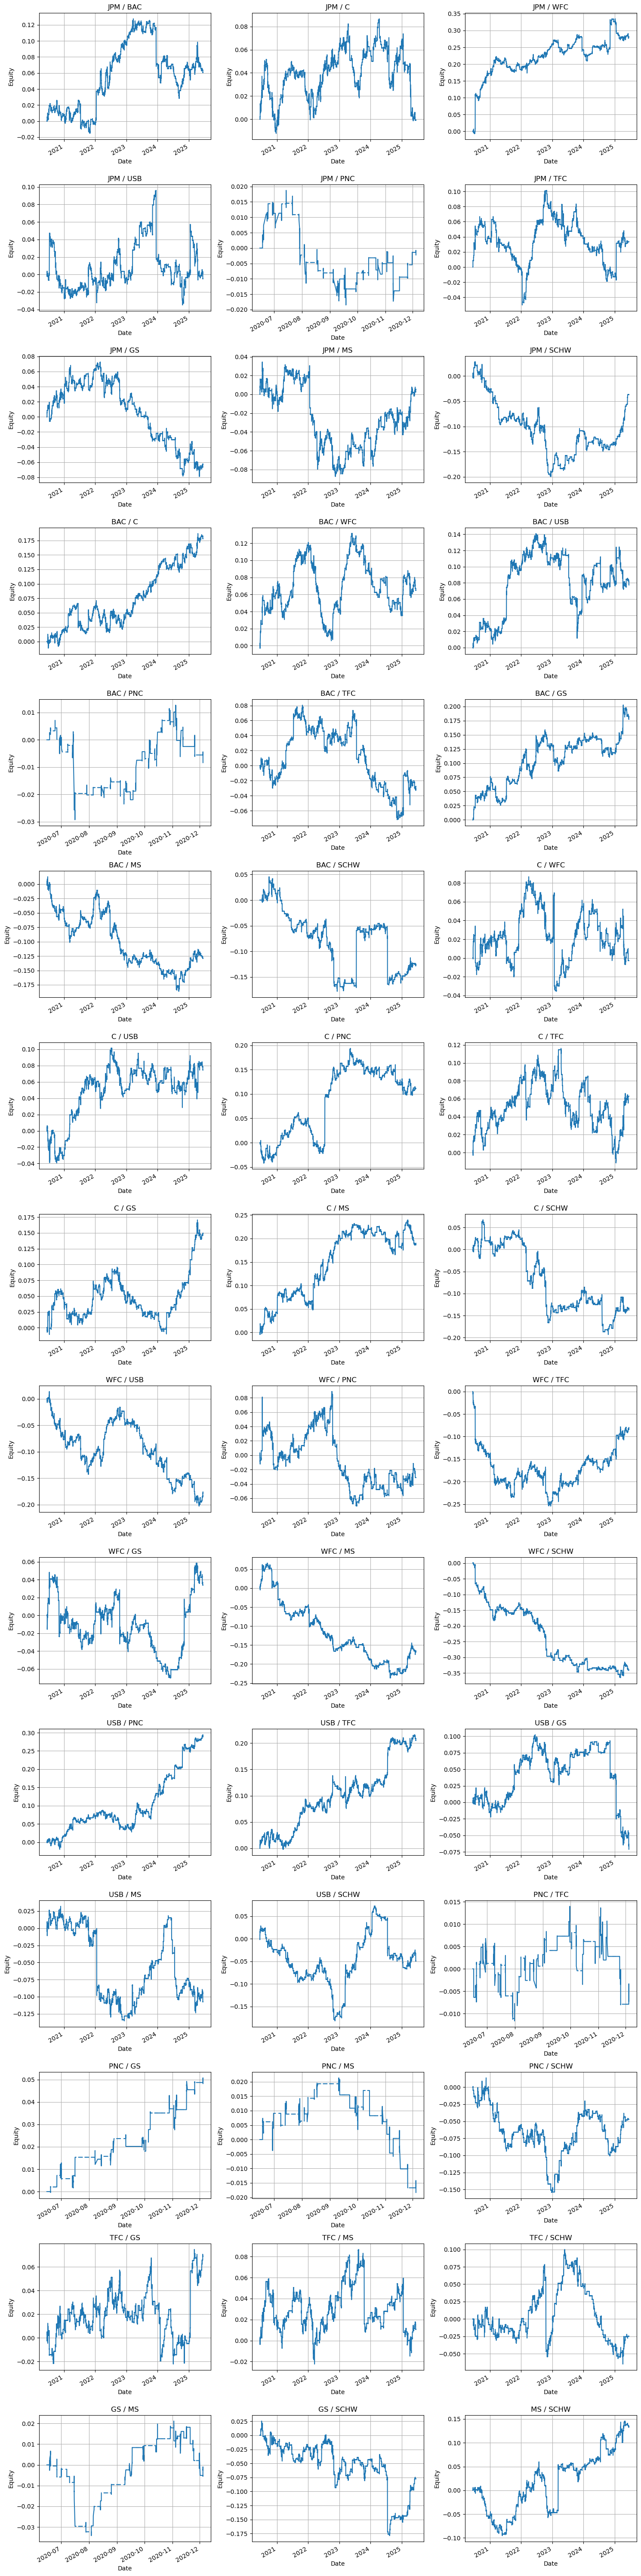

In [10]:
print_trades('resultat2.pkl')

# Now, for portfolio management, we will select the top 5 pairs based on the Sharpe ratio over a rolling 30-day window. Then, we will determine the optimal allocation for each of these 5 pairs by solving an optimization problem that maximizes the Sharpe ratio.

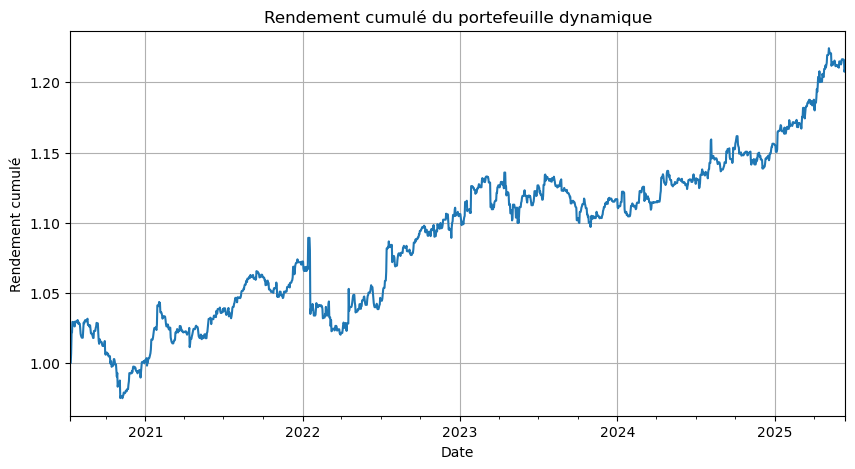


📊 Statistiques de performance du portefeuille stat-arb :
Total Return       : 20.89 %
Annual Volatility  : 4.13 %
Sharpe Ratio       : 0.66
Max Drawdown       : 6.90 %


In [7]:
from portfolio_pair.portfolio_management import DynamicPairPortfolio

# Charger tes résultats de paires
df_equity = pd.read_pickle("resultat.pkl")

# Créer et lancer le backtest
portfolio = DynamicPairPortfolio(df_equity, window=30, top_n=5, sharpe_min=0, rebalance_freq=1, MeanVarianceOpt=True)


# For an equal-weight allocation

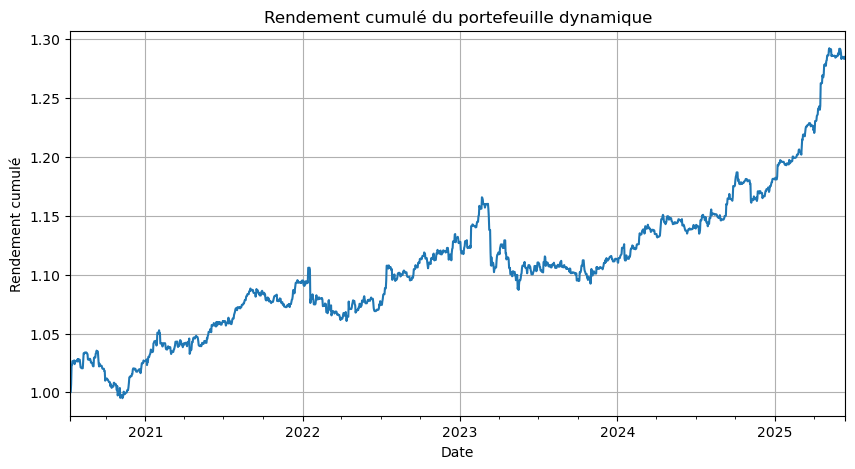


📊 Statistiques de performance du portefeuille stat-arb :
Total Return       : 28.52 %
Annual Volatility  : 3.55 %
Sharpe Ratio       : 1.01
Max Drawdown       : 7.87 %


In [8]:
portfolio = DynamicPairPortfolio(df_equity, window=30, top_n=5, sharpe_min=0, rebalance_freq=1, MeanVarianceOpt=False)


# For the second strategy, by excluding one and a half hours of trading at the market open and close.


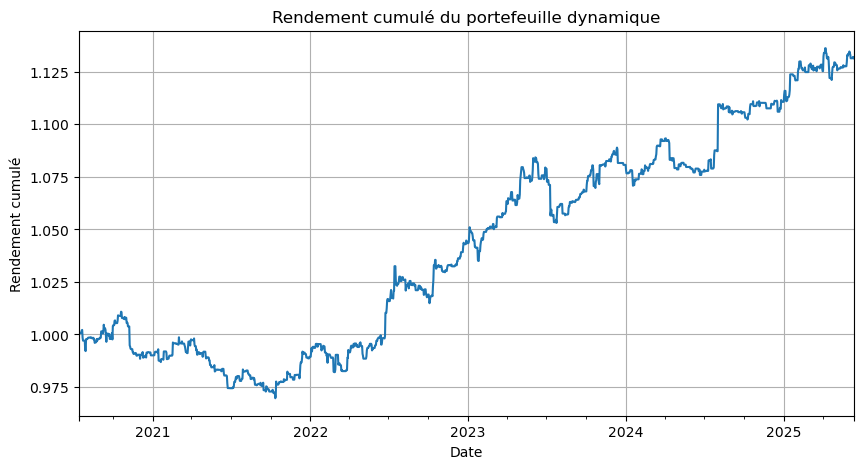


📊 Statistiques de performance du portefeuille stat-arb :
Total Return       : 13.14 %
Annual Volatility  : 2.28 %
Sharpe Ratio       : 0.77
Max Drawdown       : 4.12 %


In [11]:
# Charger tes résultats de paires
df_equity = pd.read_pickle("resultat2.pkl")

# Créer et lancer le backtest
portfolio = DynamicPairPortfolio(df_equity, window=30, top_n=5, sharpe_min=0, rebalance_freq=1, MeanVarianceOpt=True)

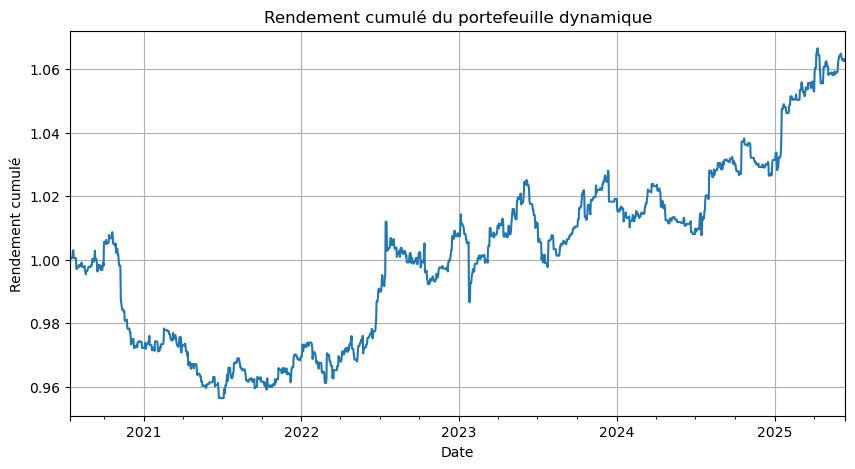


📊 Statistiques de performance du portefeuille stat-arb :
Total Return       : 6.27 %
Annual Volatility  : 2.23 %
Sharpe Ratio       : 0.39
Max Drawdown       : 5.23 %


In [12]:
portfolio = DynamicPairPortfolio(df_equity, window=30, top_n=5, sharpe_min=0, rebalance_freq=1, MeanVarianceOpt=False)